<a href="https://colab.research.google.com/github/collinwa/MPCCA/blob/model_refactor/analyze_mesa_no_geno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import torch
import mpcca_collin.MPCCA.micca_model as micca
import mpcca_collin.MPCCA.model as model
import mpcca_collin.MPCCA.mp_simulation as mp_simulation

from scipy import stats
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_printoptions(linewidth = 200)
np.set_printoptions(linewidth = 200)

In [ ]:
# exam = '1'
exam = '5'


methyl_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/methyl_cca_collated_exam' + exam + '.json'
metab_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/metab_cca_collated_exam' + exam + '.json'
exp_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/exp_cca_collated_exam' + exam + '.json'
# geno_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/geno_cca_collated_exam' + exam + '.json'
protein_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/protein_cca_collated_exam' + exam + '.json'
meta_df_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/metadata_cca_collated_exam' + exam + '.json'
pheno_df_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/phenotypes_cca_collated_exam' + exam + '.json'

parra_factor_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/para_factors_exam' + exam + '.csv'
pgm_factor_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/pgm_factors_exam' + exam + '.csv'
meta_aligned_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/meta_aligned_exam' + exam + '.csv'
pheno_aligned_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/pheno_aligned_exam' + exam + '.csv'

In [ ]:
pheno_df = pd.read_json(pheno_df_save_fn)
meta_df = pd.read_json(meta_df_save_fn)
# geno_data = pd.read_json(geno_data_save_fn)
metab_data = pd.read_json(metab_data_save_fn)
protein_data = pd.read_json(protein_data_save_fn)
exp_data = pd.read_json(exp_data_save_fn)
methyl_data = pd.read_json(methyl_data_save_fn)

n_inds = exp_data.shape[0]

In [ ]:
# geno_pca = micca.pca(torch.from_numpy(geno_data.values))
metab_pca = micca.pca(torch.from_numpy(metab_data.values))
protein_pca = micca.pca(torch.from_numpy(protein_data.values))
exp_pca = micca.pca(torch.from_numpy(exp_data.values))
methyl_pca = micca.pca(torch.from_numpy(methyl_data.values))

In [ ]:
meta_df = meta_df.sort_values(
    by=['sidno', 'NWDID', 'num_nans']).drop_duplicates(
        subset='NWDID').set_index('NWDID').loc[exp_data.index].drop(
            columns=['index', 'sidno', 'Metabolomics', 'Methylomics',
                     'Proteomics', 'Transcriptomics_PBMC', 'num_nans'])

In [ ]:
analysis_cols = ['Sex', 'Race', 'Age', 'bmi' + exam + 'c', 'RQS',
                 'seq_center', 'column_2', 'column_3', 'Summary.batch',
                 'Batch_scan', 'Bcell', 'CD4T', 'CD8T', 'Eos', 'Mono', 'Neu',
                 'NK', 'B cells', 'Plasma cells', 'T cells', 'NK cells',
                 'Monocytes', 'Macrophages', 'Dendritic cells', 'Mast cells',
                 'Eosinophils', 'Neutrophils']
meta_df = meta_df[analysis_cols]
meta_df_dummies = pd.get_dummies(meta_df)
meta_df_dummies.column_2 = meta_df_dummies.column_2.astype('uint8')
meta_df_dummies.column_3 = meta_df_dummies.column_3.astype('uint8')

In [ ]:
print(n_inds, exp_pca.mp_dim, methyl_pca.mp_dim, metab_pca.mp_dim, protein_pca.mp_dim)

652 tensor(33) tensor(35) tensor(65) tensor(24)


tensor(15)


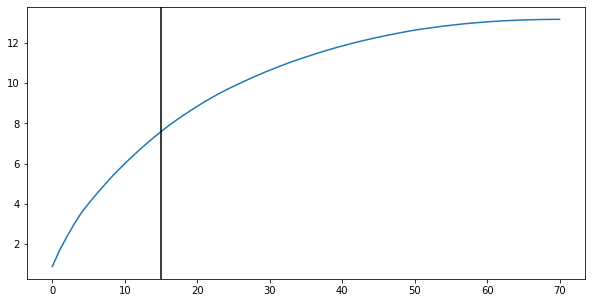

In [ ]:
# Running without genotype
# Fit all with Parra to make elbow plot
datasets = [exp_pca, methyl_pca, metab_pca, protein_pca] 
dimensions = [ds.mp_dim for ds in datasets]
parra_res = micca.micca_nopc(datasets, dimensions=dimensions)
if(exam == '1'): rho_min = 0.311571
if(exam == '5'): rho_min = 0.300501
c_shared = sum(parra_res.rho > rho_min)
print(c_shared)
plt.rcParams['figure.figsize'] = (10, 5)
rho_parra = parra_res.rho[parra_res.rho > 0]
rho_sum = torch.cumsum(rho_parra, 0)
sns.lineplot(x=range(len(rho_sum)), y=rho_sum)
plt.axvline(x = c_shared, color = 'black')

In [ ]:
c_private = [max(d - c_shared, 0) for d in dimensions]
parra_res = micca.micca_nopc([exp_pca, methyl_pca, metab_pca, protein_pca], dimensions=dimensions, c_shared=c_shared, c_private=c_private)

In [ ]:
# Make heatmap fig using just Parra results.
plot_dims = [7, 13, 17 , 5]
data = torch.cat([parra_res.C_all] + parra_res.C_private, 1).numpy()
colnames = ['Z_' + str(i) for i in range(len(parra_res.rho))] + \
    ['X_exp_' + str(i) for i in range(len(parra_res.lam_private[0]))] + \
    ['X_methyl_' + str(i) for i in range(len(parra_res.lam_private[1]))] + \
    ['X_metab_' + str(i) for i in range(len(parra_res.lam_private[2]))] + \
    ['X_protein_' + str(i) for i in range(len(parra_res.lam_private[3]))]
data_df = pd.DataFrame(data, columns=colnames, index=meta_df_dummies.index)

show_cols = ['Z_' + str(i) for i in range(c_shared)] + \
    ['X_exp_' + str(i) for i in range(plot_dims[0])] + \
    ['X_methyl_' + str(i) for i in range(plot_dims[1])] + \
    ['X_metab_' + str(i) for i in range(plot_dims[2])] + \
    ['X_protein_' + str(i) for i in range(plot_dims[3])]
# data_df = data_df[show_cols]
parra_res_df = pd.concat([meta_df_dummies, data_df], axis=1)

<AxesSubplot:>

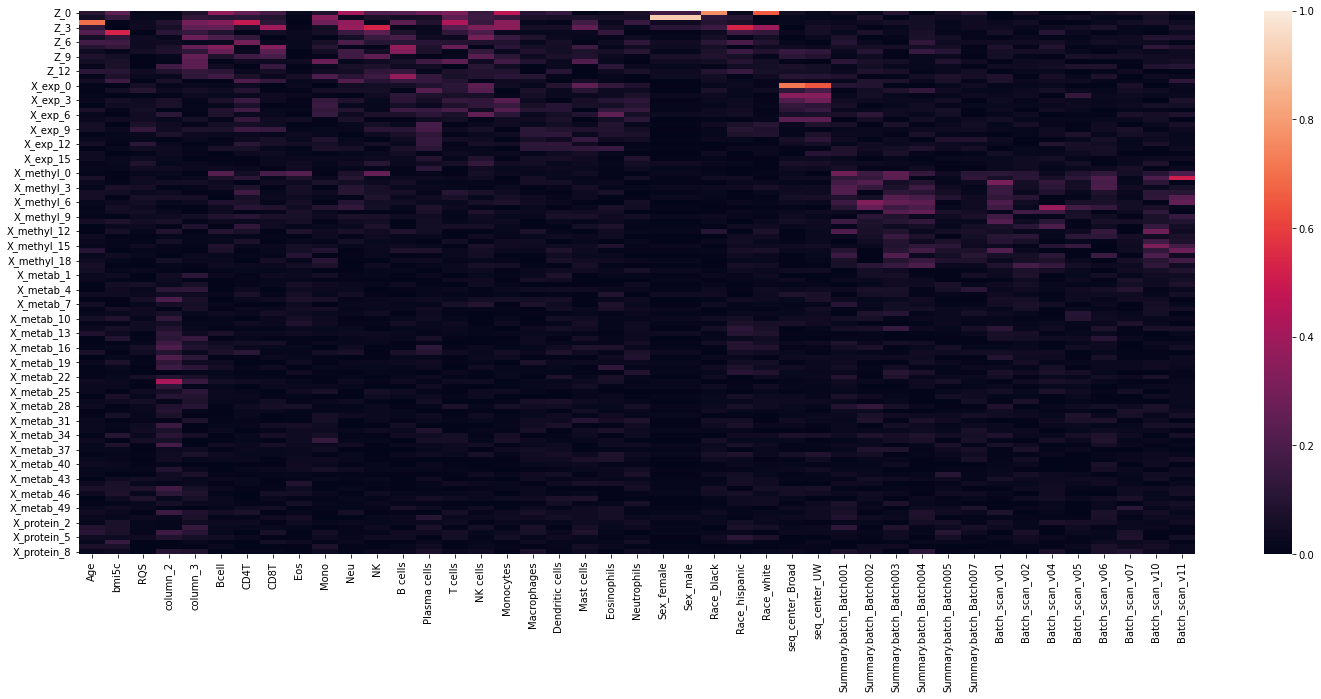

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = colnames
cor_cols = meta_df_dummies.columns
data = abs(np.corrcoef(parra_res_df.fillna(parra_res_df.mean())[data_cols], parra_res_df.fillna(parra_res_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)

In [ ]:
parra_res_df['Race'] = meta_df.Race
parra_res_df['Sex'] = meta_df.Sex
parra_res_df['seq_center'] = meta_df.seq_center

<AxesSubplot:xlabel='Z_0', ylabel='Z_2'>

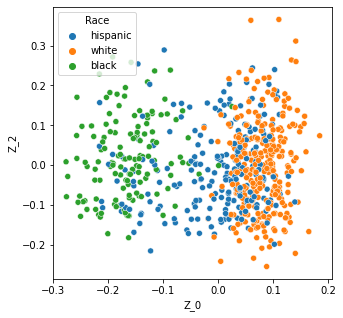

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=parra_res_df, x='Z_0', y='Z_2', hue='Race')

<AxesSubplot:xlabel='Z_1', ylabel='Z_3'>

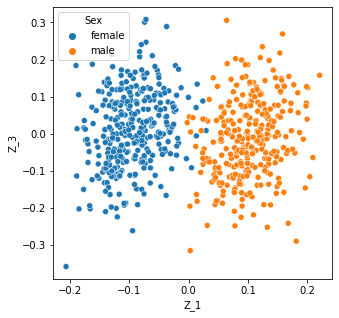

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=parra_res_df, x='Z_1', y='Z_3', hue='Sex')

<AxesSubplot:xlabel='Z_4', ylabel='Z_5'>

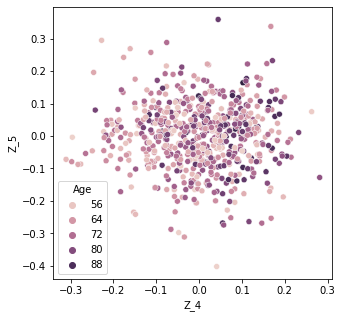

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=parra_res_df, x='Z_4', y='Z_5', hue='Age')

In [ ]:
pheno_df = pheno_df.loc[meta_df.index].drop(columns=['hba1c'])
pheno_df_dummies = pd.get_dummies(pheno_df)
parra_pheno_df = pd.concat([pheno_df_dummies, data_df], axis=1)

<AxesSubplot:>

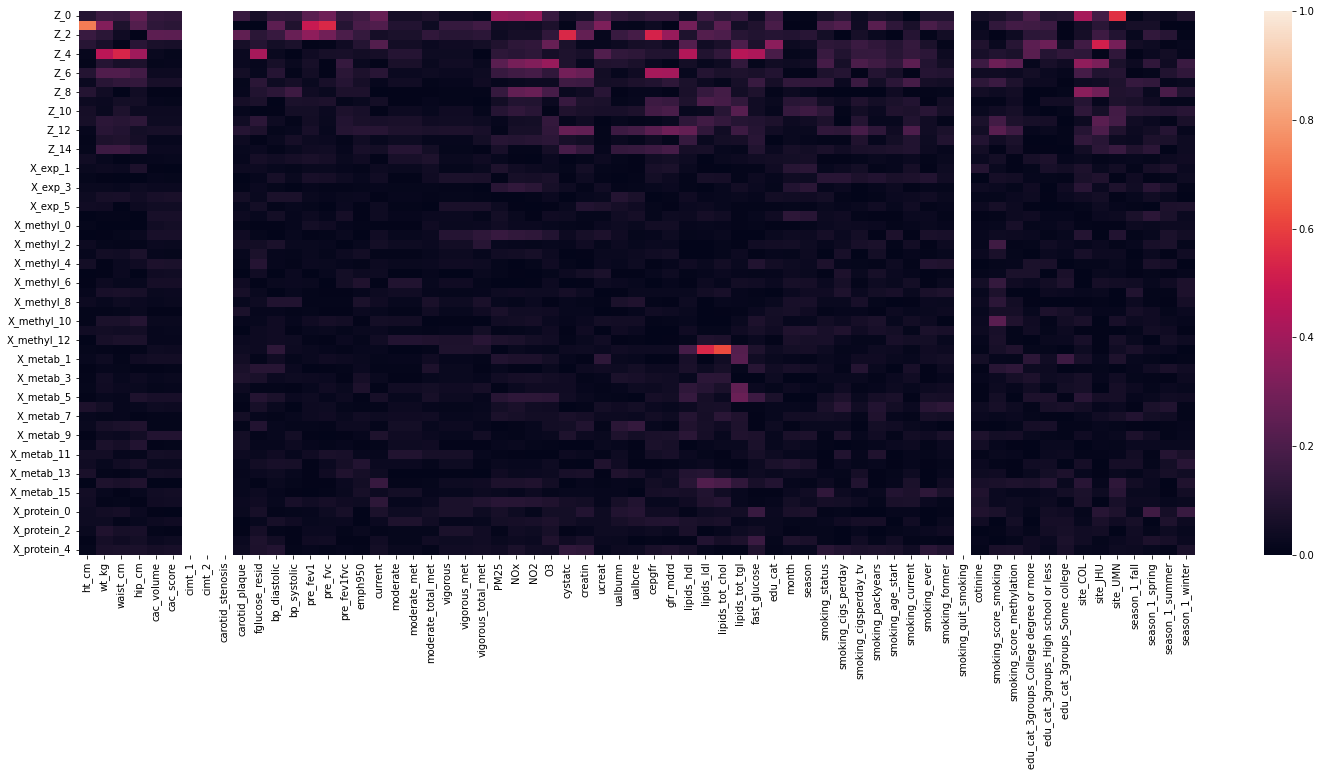

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = show_cols
cor_cols = pheno_df_dummies.columns
data = abs(np.corrcoef(parra_pheno_df.fillna(parra_pheno_df.mean())[data_cols], parra_pheno_df.fillna(parra_pheno_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)
# sns.heatmap(space_cov_cor)

In [ ]:
# exp_ds = exp_pca.U[:, 0:exp_pca.mp_dim]*np.sqrt(n_inds-1)  # 33
# methyl_ds = methyl_pca.U[:, 0:methyl_pca.mp_dim]*np.sqrt(n_inds-1)  # 49
# metab_ds = metab_pca.U[:, 0:metab_pca.mp_dim]*np.sqrt(n_inds-1)  # 66
# protein_ds = protein_pca.U[:, 0:protein_pca.mp_dim]*np.sqrt(n_inds-1)  # 29

exp_ds = exp_pca.pcs[:, 0:exp_pca.mp_dim]  # 33
methyl_ds = methyl_pca.pcs[:, 0:methyl_pca.mp_dim]  # 49
metab_ds = metab_pca.pcs[:, 0:metab_pca.mp_dim]  # 66
protein_ds = protein_pca.pcs[:, 0:protein_pca.mp_dim]  # 29

# exp_ds = exp_pca.pcs[:, 0:exp_pca.mp_dim]*np.sqrt(n_inds-1)  # 33
# methyl_ds = methyl_pca.pcs[:, 0:methyl_pca.mp_dim]*np.sqrt(n_inds-1)  # 49
# metab_ds = metab_pca.pcs[:, 0:metab_pca.mp_dim]*np.sqrt(n_inds-1)  # 66
# protein_ds = protein_pca.pcs[:, 0:protein_pca.mp_dim]*np.sqrt(n_inds-1)  # 29

# exp_ds = (exp_pca.U*np.sqrt(exp_pca.lam))[:, 0:exp_pca.mp_dim]  # 33
# methyl_ds = (methyl_pca.U*np.sqrt(methyl_pca.lam))[:, 0:methyl_pca.mp_dim]  # 49
# metab_ds = (metab_pca.U*np.sqrt(metab_pca.lam))[:, 0:metab_pca.mp_dim]  # 66
# protein_ds = (protein_pca.U*np.sqrt(protein_pca.lam))[:, 0:protein_pca.mp_dim]  # 29

# exp_ds = (exp_pca.U*np.sqrt(exp_pca.lam))[:, 0:exp_pca.mp_dim]*np.sqrt(n_inds-1)  # 33
# methyl_ds = (methyl_pca.U*np.sqrt(methyl_pca.lam))[:, 0:methyl_pca.mp_dim]*np.sqrt(n_inds-1)  # 49
# metab_ds = (metab_pca.U*np.sqrt(metab_pca.lam))[:, 0:metab_pca.mp_dim]*np.sqrt(n_inds-1)  # 66
# protein_ds = (protein_pca.U*np.sqrt(protein_pca.lam))[:, 0:protein_pca.mp_dim]*np.sqrt(n_inds-1)  # 29

datasets = [exp_ds, methyl_ds, metab_ds, protein_ds]

In [ ]:
# Now use MPCCA
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print('gpu available: using {}'.format(device))

y_concat = torch.cat(datasets, axis=1).double()

# initialize dataset dimension parameters 
x_dims = torch.tensor(c_private)  # low dimensional private structure
y_dims = torch.tensor([ds.shape[1] for ds in datasets])
d = c_shared  # low dimensional shared structure
n_steps = 5000

W_model, L_model, Phi_model = model.fit_model(y_dims, x_dims, datasets, d, y_concat, n_inds, steps=n_steps, device=device, toprint=100, method="stable")
W_model = W_model.cpu()
L_model = L_model.cpu()
Phi_model = Phi_model.cpu()

0/5000: (Wtprime-Wt)_F: 87.94883053453017 (Ltprime-Lt)_F: 70.41768993583288 (Phi_tprime-Phi_t)_F: 0.343999371104185
100/5000: (Wtprime-Wt)_F: 0.15766446607670104 (Ltprime-Lt)_F: 0.04010753621770365 (Phi_tprime-Phi_t)_F: 0.060615322294705204
200/5000: (Wtprime-Wt)_F: 0.05796656702852036 (Ltprime-Lt)_F: 0.012046961653887923 (Phi_tprime-Phi_t)_F: 0.010190406108362282
300/5000: (Wtprime-Wt)_F: 0.04718629895547123 (Ltprime-Lt)_F: 0.014732545516306931 (Phi_tprime-Phi_t)_F: 0.01525792677572978
400/5000: (Wtprime-Wt)_F: 0.04051264002303848 (Ltprime-Lt)_F: 0.014567378740460752 (Phi_tprime-Phi_t)_F: 0.00709710475060577
500/5000: (Wtprime-Wt)_F: 0.035645419685565984 (Ltprime-Lt)_F: 0.014963352894643263 (Phi_tprime-Phi_t)_F: 0.000992522837596469
600/5000: (Wtprime-Wt)_F: 0.029169738912545852 (Ltprime-Lt)_F: 0.011824686986493355 (Phi_tprime-Phi_t)_F: 0.0008766743027378966
700/5000: (Wtprime-Wt)_F: 0.025351887721539162 (Ltprime-Lt)_F: 0.011325703716978485 (Phi_tprime-Phi_t)_F: 0.0005436584200342957


<Figure size 1080x1080 with 0 Axes>

In [ ]:
posterior_z, posterior_x = model.project_latent(W_model, L_model, Phi_model, d, y_concat)

posterior_z_exp, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 0)
posterior_z_methyl, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 1)
posterior_z_metab, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 2)
posterior_z_protein, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 3)

# get the interset correlation as per Parra 2018
latent_data_list = [posterior_z_exp, posterior_z_methyl, posterior_z_metab, posterior_z_protein]
rho, rb, rw = model.compute_ISC(latent_data_list)

In [ ]:
print(np.sort(rho))

[0.342984   0.3464321  0.36222726 0.367717   0.4105107  0.4450389  0.4562623  0.48871744 0.5111632  0.5266518  0.53507733 0.54072094 0.5765311  0.5934395  0.6421125 ]


In [ ]:
x_dimsum = np.cumsum(x_dims)

Z_orth = torch.linalg.svd(posterior_z, full_matrices=False).U
# X_geno_orth = torch.linalg.svd(posterior_x[:, 0:x_dimsum[0]], full_matrices=False).U
X_exp_orth = torch.linalg.svd(posterior_x[:, 0:x_dimsum[0]], full_matrices=False).U
X_methyl_orth = torch.linalg.svd(posterior_x[:, x_dimsum[0]:x_dimsum[1]], full_matrices=False).U
X_metab_orth = torch.linalg.svd(posterior_x[:, x_dimsum[1]:x_dimsum[2]], full_matrices=False).U
X_protein_orth = torch.linalg.svd(posterior_x[:, x_dimsum[2]:x_dimsum[3]], full_matrices=False).U

In [ ]:
data = torch.cat([Z_orth, X_exp_orth, X_methyl_orth, X_metab_orth, X_protein_orth], 1).numpy()
colnames = ['Z_' + str(i) for i in range(c_shared)] + \
    ['X_exp_' + str(i) for i in range(x_dims[0])] + \
    ['X_methyl_' + str(i) for i in range(x_dims[1])] + \
    ['X_metab_' + str(i) for i in range(x_dims[2])] + \
    ['X_protein_' + str(i) for i in range(x_dims[3])]
ZX_df = pd.DataFrame(data, columns=colnames, index=meta_df_dummies.index)
orth_res = pd.concat([meta_df_dummies, ZX_df], axis=1)

<AxesSubplot:>

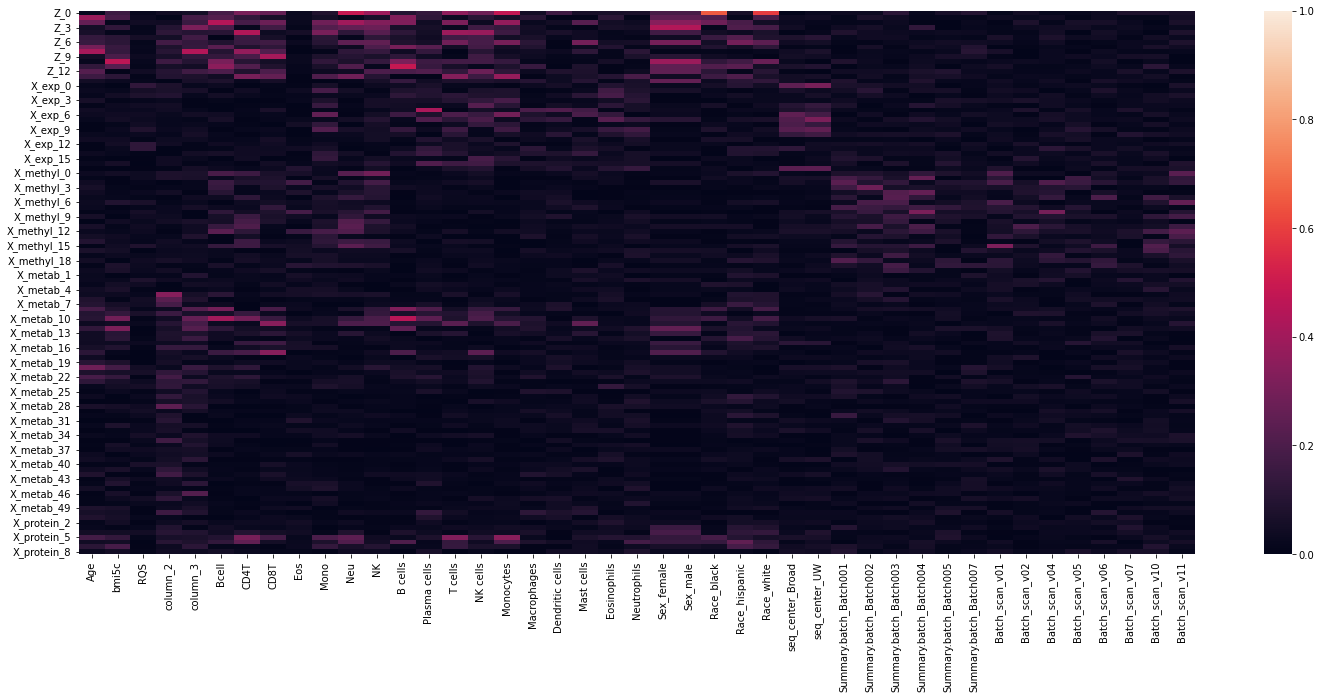

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = colnames
cor_cols = meta_df_dummies.columns
data = abs(np.corrcoef(orth_res.fillna(orth_res.mean())[data_cols], orth_res.fillna(orth_res.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)

In [ ]:
prob_pheno_df = pd.concat([pheno_df_dummies, ZX_df], axis=1)

<AxesSubplot:>

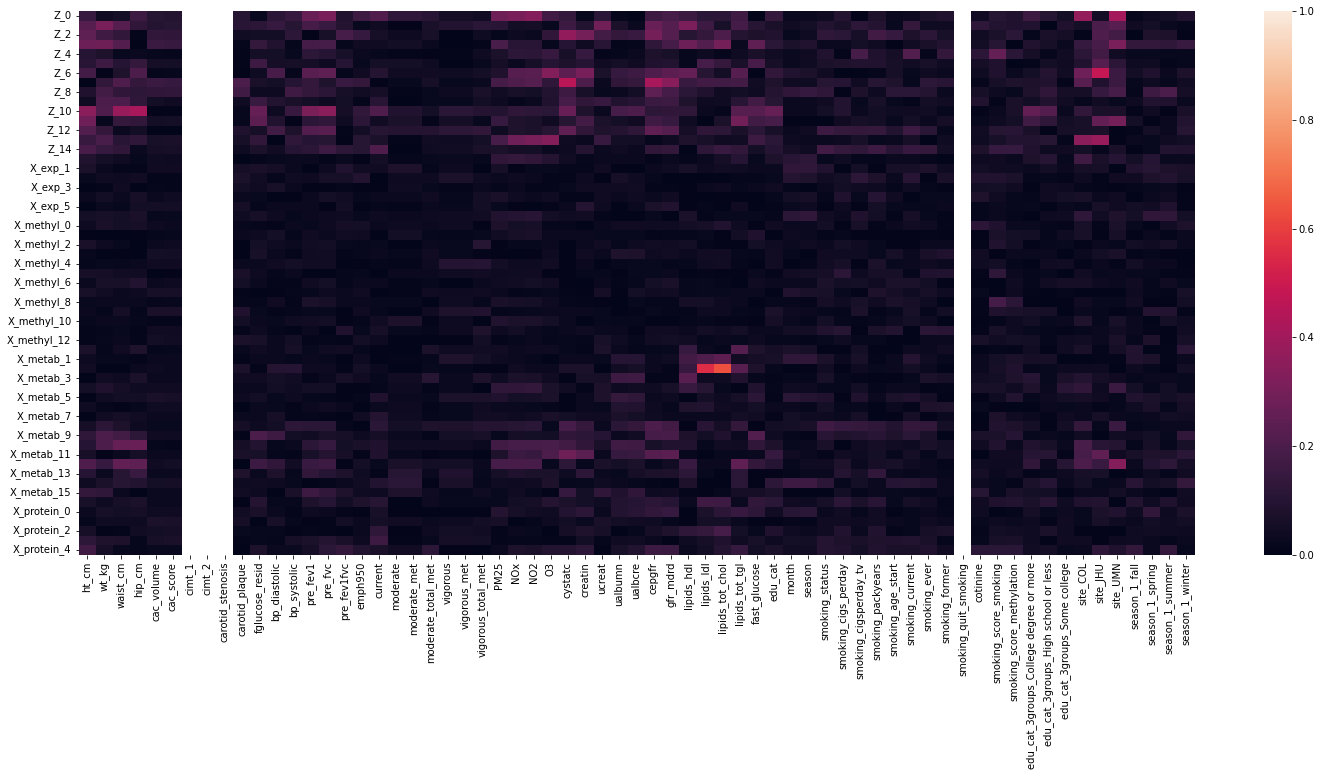

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = show_cols
cor_cols = pheno_df_dummies.columns
data = abs(np.corrcoef(prob_pheno_df.fillna(prob_pheno_df.mean())[data_cols], prob_pheno_df.fillna(prob_pheno_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)
# sns.heatmap(space_cov_cor)

In [ ]:
meta_df

,Sex,Race,Age,bmi5c,RQS,seq_center,column_2,column_3,Summary.batch,Batch_scan,...,B cells,Plasma cells,T cells,NK cells,Monocytes,Macrophages,Dendritic cells,Mast cells,Eosinophils,Neutrophils
NWD101761,female,hispanic,61,39.991395,8.056686,Broad,1.0,0.0,Batch002,v10,...,0.017113,0.009274,0.440689,0.126696,0.383918,0.001815,0.000098,0.018774,0.000000,0.001624
NWD103464,female,hispanic,59,35.563694,NaN,None,0.0,0.0,Batch002,v01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NWD104274,male,white,74,20.288232,NaN,UW,0.0,1.0,Batch003,v06,...,0.014029,0.006631,0.299843,0.219822,0.442929,0.000025,0.000000,0.016721,0.000000,0.000000
NWD105109,male,white,68,32.178103,NaN,UW,0.0,0.0,Batch001,v01,...,0.014174,0.006642,0.271807,0.208743,0.474489,0.003589,0.000000,0.020556,0.000000,0.000000
NWD108116,male,black,58,28.471403,8.822969,Broad,0.0,0.0,Batch003,v06,...,0.014438,0.006190,0.450694,0.167856,0.343525,0.001759,0.000000,0.015028,0.000510,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NWD989585,male,hispanic,58,27.511693,8.882389,Broad,1.0,0.0,Batch001,v01,...,0.015720,0.005530,0.488228,0.200652,0.286081,0.000000,0.000000,0.002782,0.000958,0.000048
NWD989947,female,hispanic,71,26.873387,10.000000,Broad,0.0,0.0,Batch003,v01,...,0.020223,0.004746,0.419129,0.042758,0.497852,0.002385,0.000000,0.012908,0.000000,0.000000
NWD993367,female,white,70,33.197527,8.865249,Broad,0.0,1.0,Batch003,v06,...,0.014404,0.006836,0.340813,0.140782,0.468578,0.001753,0.000000,0.020632,0.000000,0.006203
NWD993431,female,black,80,30.771714,NaN,None,1.0,0.0,Batch002,v01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_df.to_csv(parra_factor_save_fn, index_label="NWDID")
ZX_df.to_csv(pgm_factor_save_fn, index_label="NWDID")
meta_df.to_csv(meta_aligned_save_fn, index_label="NWDID")
pheno_df.to_csv(pheno_aligned_save_fn, index_label="NWDID")